In [1]:
!pip install pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [93]:
import pandas as pd
import os
import re

In [94]:
def parse_usages(usage_string):
    usages = []
    usage_string = usage_string.replace("),C",")\tC")
    usage_string = usage_string.split("\t")
    usages_pattern = r"[A-Za-z]PU: \([^)]*\)"
    cpu_usage_pattern = r"maxrss: (\d+MiB)"
    gpu_usage_pattern = r"U: (\d+MiB)"
    mapper = {
        0: "before (MiB)",
        1: "after (MiB)"
    }
    for i, moments in enumerate(usage_string):
            matches = re.findall(usages_pattern, moments)
            for match in matches:
                match = match.replace(",","")
                cpu = re.findall(cpu_usage_pattern, match)
                gpu = re.findall(gpu_usage_pattern, match)
                if match[:3] == "CPU":
                    usages.append({f"{match[:3]}-{mapper[i]}":int(cpu[0].replace("MiB",""))})
                elif match[:3] == "GPU":
                    usages.append({f"{match[:3]}-{mapper[i]}":int(gpu[0].replace("MiB",""))})                    
    return usages
            
        

In [95]:
def parse_file(file):
    lazy_load = True if "--lazy-load" in file else False
    vllm_tensorized = True if "--plaid-mode"in file else False
    df = pd.read_csv(file)
    rows = []
    for i in range(len(df)):
        row = df.iloc[i]
        load_format = row.name[0]
        model = row.name[1]
        duration = row[-2]
        cache = row[-1]
        to_concat = row.name[2:]
        mem_before_after = ",".join(to_concat)
        vals = {}
        vals.update({"load_format":load_format})
        vals.update({"model":model})
        for dic in parse_usages(mem_before_after):
            vals.update(dic)
        vals.update({"duration(s)":duration})
        vals.update({"cache_hit":cache})
        vals.update({"lazy_load":lazy_load})
        vals.update({"vllm_tensorized":vllm_tensorized})
        cpu_diff = vals["CPU-after (MiB)"] - vals["CPU-before (MiB)"]
        gpu_diff = vals["GPU-after (MiB)"] - vals["GPU-before (MiB)"]
        vals.update({"CPU-diff-MiB": cpu_diff})
        vals.update({"GPU-diff-MiB": gpu_diff})
        rows.append(vals)
    return pd.DataFrame(rows)


In [96]:
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)

In [231]:
files = [file for file in os.listdir() if file.isnumeric()]
dfs = []
for file in files:
    load_type = os.listdir(file)[0]
    print(load_type)
    for i, model in enumerate(os.listdir(f"{file}/{load_type}")):
        model_ref_1 = os.listdir(f"{file}/{load_type}")[i]
        model_ref_2 = os.listdir(f"{file}/{load_type}/{model_ref_1}")[0]
        localities = os.listdir(f"{file}/{load_type}/{model_ref_1}/{model_ref_2}")
        for locality in localities:
            subpath = f"{file}/{load_type}/{model_ref_1}/{model_ref_2}/{locality}"
            benchmark_files = os.listdir(subpath)
            benchmark = "results_checkpoint_500_vals.csv"
            print(f"Reading {subpath}/{benchmark}")
            created_df = parse_file(f"{subpath}/{benchmark}")
            created_df['local_or_not_local'] = locality
            dfs.append(created_df)
df = pd.concat(dfs)
        

tensorizer--plaid-mode--lazy-load
Reading 1709783929/tensorizer--plaid-mode--lazy-load/EleutherAI/pythia-1.4b/non-local/results_checkpoint_500_vals.csv
Reading 1709783929/tensorizer--plaid-mode--lazy-load/EleutherAI/pythia-1.4b/local/results_checkpoint_500_vals.csv
Reading 1709783929/tensorizer--plaid-mode--lazy-load/mistralai/Mistral-7B-v0.1/non-local/results_checkpoint_500_vals.csv
Reading 1709783929/tensorizer--plaid-mode--lazy-load/mistralai/Mistral-7B-v0.1/local/results_checkpoint_500_vals.csv
Reading 1709783929/tensorizer--plaid-mode--lazy-load/meta-llama/Llama-2-13b-hf/non-local/results_checkpoint_500_vals.csv
Reading 1709783929/tensorizer--plaid-mode--lazy-load/meta-llama/Llama-2-13b-hf/local/results_checkpoint_500_vals.csv
tensorizer--lazy-load
Reading 1709782942/tensorizer--lazy-load/EleutherAI/pythia-1.4b/non-local/results_checkpoint_500_vals.csv
Reading 1709782942/tensorizer--lazy-load/EleutherAI/pythia-1.4b/local/results_checkpoint_500_vals.csv
Reading 1709782942/tensorize

In [232]:
df['vllm_tensorized'] = ['vLLM tensorized' if ((x['model'] == "meta-llama/Llama-2-13b-hf") & (x["vllm_tensorized"] == True)) else 'HF tensorized' for x in df.iloc]

In [233]:
df

,load_format,model,CPU-before (MiB),GPU-before (MiB),CPU-after (MiB),GPU-after (MiB),duration(s),cache_hit,lazy_load,vllm_tensorized,CPU-diff-MiB,GPU-diff-MiB,local_or_not_local
0,tensorizer,EleutherAI/pythia-1.4b,994,262,8932,44548,10.327893,NaN,True,HF tensorized,7938,44286,non-local
1,tensorizer,EleutherAI/pythia-1.4b,994,262,8795,44548,8.975955,NaN,True,HF tensorized,7801,44286,non-local
2,tensorizer,EleutherAI/pythia-1.4b,994,262,8782,44548,8.947993,NaN,True,HF tensorized,7788,44286,non-local
3,tensorizer,EleutherAI/pythia-1.4b,994,262,8761,44548,8.965463,NaN,True,HF tensorized,7767,44286,non-local
4,tensorizer,EleutherAI/pythia-1.4b,994,262,8763,44548,8.830160,NaN,True,HF tensorized,7769,44286,non-local
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,tensorizer,meta-llama/Llama-2-13b-hf,994,262,7627,44262,10.603077,NaN,False,vLLM tensorized,6633,44000,local
1496,tensorizer,meta-llama/Llama-2-13b-hf,995,262,7628,44262,10.488320,NaN,False,vLLM tensorized,6633,44000,local
1497,tensorizer,meta-llama/Llama-2-13b-hf,995,262,7628,44262,10.549857,NaN,False,vLLM tensorized,6633,44000,local
1498,tensorizer,meta-llama/Llama-2-13b-hf,995,262,7628,44262,10.470870,NaN,False,vLLM tensorized,6633,44000,local


In [234]:
df['lazy_load'] = ['lazy_load' if x == True else '' for x in df['lazy_load']]

In [235]:
df

,load_format,model,CPU-before (MiB),GPU-before (MiB),CPU-after (MiB),GPU-after (MiB),duration(s),cache_hit,lazy_load,vllm_tensorized,CPU-diff-MiB,GPU-diff-MiB,local_or_not_local
0,tensorizer,EleutherAI/pythia-1.4b,994,262,8932,44548,10.327893,NaN,lazy_load,HF tensorized,7938,44286,non-local
1,tensorizer,EleutherAI/pythia-1.4b,994,262,8795,44548,8.975955,NaN,lazy_load,HF tensorized,7801,44286,non-local
2,tensorizer,EleutherAI/pythia-1.4b,994,262,8782,44548,8.947993,NaN,lazy_load,HF tensorized,7788,44286,non-local
3,tensorizer,EleutherAI/pythia-1.4b,994,262,8761,44548,8.965463,NaN,lazy_load,HF tensorized,7767,44286,non-local
4,tensorizer,EleutherAI/pythia-1.4b,994,262,8763,44548,8.830160,NaN,lazy_load,HF tensorized,7769,44286,non-local
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,tensorizer,meta-llama/Llama-2-13b-hf,994,262,7627,44262,10.603077,NaN,,vLLM tensorized,6633,44000,local
1496,tensorizer,meta-llama/Llama-2-13b-hf,995,262,7628,44262,10.488320,NaN,,vLLM tensorized,6633,44000,local
1497,tensorizer,meta-llama/Llama-2-13b-hf,995,262,7628,44262,10.549857,NaN,,vLLM tensorized,6633,44000,local
1498,tensorizer,meta-llama/Llama-2-13b-hf,995,262,7628,44262,10.470870,NaN,,vLLM tensorized,6633,44000,local


In [236]:
set(df['local_or_not_local'])

{'local', 'non-local'}

In [237]:
df = df.drop_duplicates()

In [238]:
df

,load_format,model,CPU-before (MiB),GPU-before (MiB),CPU-after (MiB),GPU-after (MiB),duration(s),cache_hit,lazy_load,vllm_tensorized,CPU-diff-MiB,GPU-diff-MiB,local_or_not_local
0,tensorizer,EleutherAI/pythia-1.4b,994,262,8932,44548,10.327893,NaN,lazy_load,HF tensorized,7938,44286,non-local
1,tensorizer,EleutherAI/pythia-1.4b,994,262,8795,44548,8.975955,NaN,lazy_load,HF tensorized,7801,44286,non-local
2,tensorizer,EleutherAI/pythia-1.4b,994,262,8782,44548,8.947993,NaN,lazy_load,HF tensorized,7788,44286,non-local
3,tensorizer,EleutherAI/pythia-1.4b,994,262,8761,44548,8.965463,NaN,lazy_load,HF tensorized,7767,44286,non-local
4,tensorizer,EleutherAI/pythia-1.4b,994,262,8763,44548,8.830160,NaN,lazy_load,HF tensorized,7769,44286,non-local
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,tensorizer,meta-llama/Llama-2-13b-hf,994,262,7627,44262,10.603077,NaN,,vLLM tensorized,6633,44000,local
1496,tensorizer,meta-llama/Llama-2-13b-hf,995,262,7628,44262,10.488320,NaN,,vLLM tensorized,6633,44000,local
1497,tensorizer,meta-llama/Llama-2-13b-hf,995,262,7628,44262,10.549857,NaN,,vLLM tensorized,6633,44000,local
1498,tensorizer,meta-llama/Llama-2-13b-hf,995,262,7628,44262,10.470870,NaN,,vLLM tensorized,6633,44000,local


In [239]:
df.sort_values(by='duration(s)', ascending=False)

,load_format,model,CPU-before (MiB),GPU-before (MiB),CPU-after (MiB),GPU-after (MiB),duration(s),cache_hit,lazy_load,vllm_tensorized,CPU-diff-MiB,GPU-diff-MiB,local_or_not_local
1000,tensorizer,meta-llama/Llama-2-13b-hf,996,262,27003,44654,99.123002,NaN,,HF tensorized,26007,44392,non-local
1000,tensorizer,meta-llama/Llama-2-13b-hf,996,262,27003,44654,99.123002,NaN,,HF tensorized,26007,44392,local
1000,tensorizer,meta-llama/Llama-2-13b-hf,995,262,27001,44654,86.065934,NaN,lazy_load,HF tensorized,26006,44392,non-local
1000,tensorizer,meta-llama/Llama-2-13b-hf,995,262,27001,44654,86.065934,NaN,lazy_load,HF tensorized,26006,44392,local
500,tensorizer,mistralai/Mistral-7B-v0.1,996,262,16734,40880,54.902972,NaN,lazy_load,HF tensorized,15738,40618,non-local
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,tensorizer,EleutherAI/pythia-1.4b,995,262,8804,44548,8.502446,NaN,,HF tensorized,7809,44286,non-local
33,tensorizer,EleutherAI/pythia-1.4b,994,262,8806,44548,8.491704,NaN,,HF tensorized,7812,44286,local
33,tensorizer,EleutherAI/pythia-1.4b,994,262,8806,44548,8.491704,NaN,,HF tensorized,7812,44286,non-local
452,tensorizer,EleutherAI/pythia-1.4b,994,262,8802,44548,8.457664,NaN,,HF tensorized,7808,44286,local


In [240]:
df['model'] = [x.split("/")[1] for x in df['model']]

/tmp/ipykernel_139913/268243849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = [x.split("/")[1] for x in df['model']]


In [241]:
df['group'] = ''

/tmp/ipykernel_139913/2100526381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = ''


In [242]:
df = df[df['lazy_load'] == '']

In [243]:
df[df['model'] == 'meta-llama/Llama-2-13b-hf']

,load_format,model,CPU-before (MiB),GPU-before (MiB),CPU-after (MiB),GPU-after (MiB),duration(s),cache_hit,lazy_load,vllm_tensorized,CPU-diff-MiB,GPU-diff-MiB,local_or_not_local,group


In [244]:
df

,load_format,model,CPU-before (MiB),GPU-before (MiB),CPU-after (MiB),GPU-after (MiB),duration(s),cache_hit,lazy_load,vllm_tensorized,CPU-diff-MiB,GPU-diff-MiB,local_or_not_local,group
0,tensorizer,pythia-1.4b,996,262,8805,44548,9.920786,NaN,,HF tensorized,7809,44286,non-local,
1,tensorizer,pythia-1.4b,996,262,8763,44548,8.822507,NaN,,HF tensorized,7767,44286,non-local,
2,tensorizer,pythia-1.4b,996,262,8806,44548,8.898317,NaN,,HF tensorized,7810,44286,non-local,
3,tensorizer,pythia-1.4b,996,262,8809,44548,8.951450,NaN,,HF tensorized,7813,44286,non-local,
4,tensorizer,pythia-1.4b,996,262,8815,44548,9.213131,NaN,,HF tensorized,7819,44286,non-local,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,tensorizer,Llama-2-13b-hf,994,262,7627,44262,10.603077,NaN,,vLLM tensorized,6633,44000,local,
1496,tensorizer,Llama-2-13b-hf,995,262,7628,44262,10.488320,NaN,,vLLM tensorized,6633,44000,local,
1497,tensorizer,Llama-2-13b-hf,995,262,7628,44262,10.549857,NaN,,vLLM tensorized,6633,44000,local,
1498,tensorizer,Llama-2-13b-hf,995,262,7628,44262,10.470870,NaN,,vLLM tensorized,6633,44000,local,


In [245]:
df

,load_format,model,CPU-before (MiB),GPU-before (MiB),CPU-after (MiB),GPU-after (MiB),duration(s),cache_hit,lazy_load,vllm_tensorized,CPU-diff-MiB,GPU-diff-MiB,local_or_not_local,group
0,tensorizer,pythia-1.4b,996,262,8805,44548,9.920786,NaN,,HF tensorized,7809,44286,non-local,
1,tensorizer,pythia-1.4b,996,262,8763,44548,8.822507,NaN,,HF tensorized,7767,44286,non-local,
2,tensorizer,pythia-1.4b,996,262,8806,44548,8.898317,NaN,,HF tensorized,7810,44286,non-local,
3,tensorizer,pythia-1.4b,996,262,8809,44548,8.951450,NaN,,HF tensorized,7813,44286,non-local,
4,tensorizer,pythia-1.4b,996,262,8815,44548,9.213131,NaN,,HF tensorized,7819,44286,non-local,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,tensorizer,Llama-2-13b-hf,994,262,7627,44262,10.603077,NaN,,vLLM tensorized,6633,44000,local,
1496,tensorizer,Llama-2-13b-hf,995,262,7628,44262,10.488320,NaN,,vLLM tensorized,6633,44000,local,
1497,tensorizer,Llama-2-13b-hf,995,262,7628,44262,10.549857,NaN,,vLLM tensorized,6633,44000,local,
1498,tensorizer,Llama-2-13b-hf,995,262,7628,44262,10.470870,NaN,,vLLM tensorized,6633,44000,local,


/tmp/ipykernel_139913/2410749534.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['\n'.join(textwrap.wrap(label.get_text(), 15)) for label in ax.get_xticklabels()], fontsize=12)
/tmp/ipykernel_139913/2410749534.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['\n'.join(textwrap.wrap(label.get_text(), 15)) for label in ax.get_xticklabels()], fontsize=12)


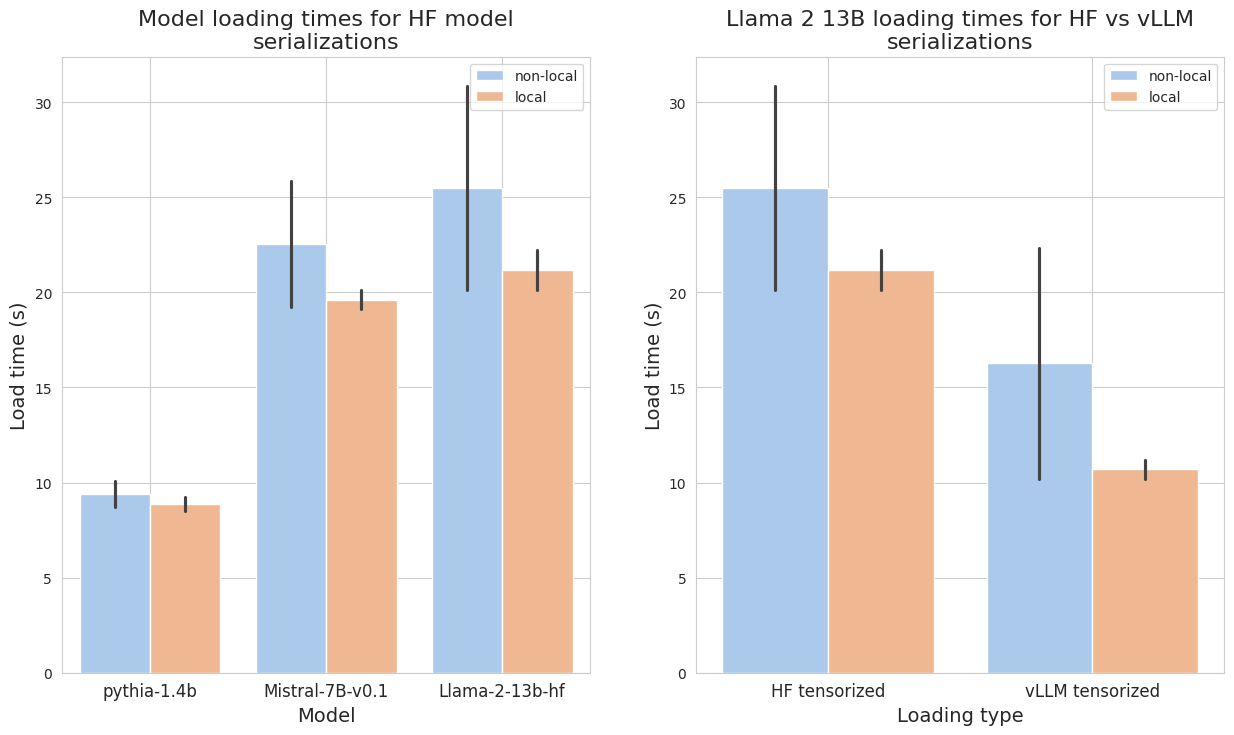

In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import textwrap

# Continue with your existing code
def join_strings(row):
    group = ' '.join([row['vllm_tensorized'], str(row['lazy_load'])])
    cleaned_group = re.sub(' +', ' ', group)  # replace multiple '-' with a single '-'
    return cleaned_group.strip(' ')  # remove '-' at the start and end of the string

df['group'] = df.apply(join_strings, axis=1)

# Remove outliers
Q1 = df['duration(s)'].quantile(0.05)
Q3 = df['duration(s)'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['duration(s)'] < (Q1 - 1.5 * IQR)) | (df['duration(s)'] > (Q3 + 1.5 * IQR)))]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Set the seaborn style
sns.set_style("whitegrid")

# Plot 1: All 3 models without 'plaid_mode'
subset1 = df[df['vllm_tensorized'] == 'HF tensorized']
sns.barplot(x='model', y='duration(s)', hue='local_or_not_local', data=subset1, ax=axs[0], ci='sd', palette='pastel')
axs[0].set_title(textwrap.fill('Model loading times for HF model serializations', 40), fontsize=16)
axs[0].set_xlabel('Model', fontsize=14)


# Plot 2: 'llama 2 13b' with and without 'plaid_mode'
subset2 = df[df['model'] == 'Llama-2-13b-hf']
sns.barplot(x='vllm_tensorized', y='duration(s)', hue='local_or_not_local', data=subset2, ax=axs[1], ci='sd', palette='pastel')
axs[1].set_title(textwrap.fill('Llama 2 13B loading times for HF vs vLLM serializations', 40), fontsize=16)
axs[1].set_xlabel('Loading type', fontsize=14)

for ax in axs:
    ax.set_ylabel('Load time (s)', fontsize=14)
    ax.grid(True)
    ax.legend().set_title('')
    # Wrap x-axis labels
    ax.set_xticklabels(['\n'.join(textwrap.wrap(label.get_text(), 15)) for label in ax.get_xticklabels()], fontsize=12)

plt.savefig("Benchmark.jpg")

In [11]:
set(df['model'])

{'meta-llama/Llama-2-13b-hf'}

In [19]:
grouped.mean()['local']

group
EleutherAI/pythia-1.4btensorizer--                       8.994465
EleutherAI/pythia-1.4btensorizer--lazy_load              9.278009
EleutherAI/pythia-1.4btensorizer-plaid_mode-             8.781135
EleutherAI/pythia-1.4btensorizer-plaid_mode-lazy_load    9.126989
Name: duration(s), dtype: float64